In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

In [2]:
def MAKE_POS_MATRIX(pos):
    x,y,z = pos[0], pos[1], pos[2]
    X = np.zeros((N,N))
    Y = np.zeros((N,N))
    Z = np.zeros((N,N))
    for i in range(N):
        X[i] = np.roll(x,-i)
        Y[i] = np.roll(y,-i)
        Z[i] = np.roll(z,-i)
    return np.vstack((np.expand_dims(X,axis=0),np.expand_dims(Y,axis=0),np.expand_dims(Z,axis=0)))

def MAKE_MASS_MATRIX(mass):
    M = np.zeros((N,N))
    for i in range(N):
        M[i] = np.roll(mass,-i)
    return M
        
def GET_ACCELERATION(X,M):
    pos = np.expand_dims(X[:,:,0],axis=2)
    return ((((X[:,:,1:]-pos)**2).sum(axis=0))**-1.5*M[:,1:]*(X[:,:,1:]-pos)).sum(axis=2)

def DKD_SCHEME(pos,vel,M,dt):
    pos += vel*0.5*dt
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    vel += A*dt
    pos += vel*0.5*dt
    X = MAKE_POS_MATRIX(pos)
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, energy

def KDK_SCHEME(pos,vel,M,A,dt):
    vel += A*0.5*dt
    pos += vel*dt
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    vel += A*0.5*dt
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, A, energy

def RK4_SCHEME(pos,vel,M,X,A,dt):
    k_1_vel = A
    k_1_pos = vel
    X = MAKE_POS_MATRIX(pos+k_1_pos*dt/2.)
    k_2_vel = GET_ACCELERATION(X,M)
    k_2_pos = vel + k_1_vel*dt/2.
    X = MAKE_POS_MATRIX(pos+k_2_pos*dt/2.)
    k_3_vel = GET_ACCELERATION(X,M)
    k_3_pos = vel + k_2_vel*dt/2.
    X = MAKE_POS_MATRIX(pos+k_3_pos*dt)
    k_4_vel = GET_ACCELERATION(X,M)
    k_4_pos = vel + k_3_vel*dt
    pos += dt/6.*(k_1_pos+2.*k_2_pos+2.*k_3_pos+k_4_pos)
    vel += dt/6.*(k_1_vel+2.*k_2_vel+2.*k_3_vel+k_4_vel)
    X = MAKE_POS_MATRIX(pos)
    A = GET_ACCELERATION(X,M)
    energy = GET_ENERGY(X,M,vel,mass)
    return pos, vel, X, A, energy

def GET_ENERGY(X,M,vel,mass):
    kinetic = (mass*vel**2).sum()
    pos = np.expand_dims(X[:,:,0],axis=2)
    potential = -(((M[:,1:]*(((X[:,:,1:]-pos)**2).sum(axis=0))**-0.5).sum(axis=1))*mass).sum()
    return 0.5*(kinetic + potential)

def GET_ERROR(pos,pos_analytic,vel,vel_analytic):
    error_pos = (((pos-pos_analytic)**2).mean()/(pos_analytic**2).mean())**0.5
    error_vel = (((vel-vel_analytic)**2).mean()/(vel_analytic**2).mean())**0.5
    return error_pos, error_vel

def GET_ANALYTIC_RESULT(t, theta_0):
    theta = theta_0+v_mag*t
    x_analytic = np.cos(theta)
    y_analytic = np.sin(theta)
    z_analytic = np.zeros(N)
    pos_analytic = np.vstack((x_analytic,y_analytic,z_analytic))
    vx_analytic = v_mag*np.cos(theta+np.pi/2)
    vy_analytic = v_mag*np.sin(theta+np.pi/2)
    vz_analytic = np.zeros(N)
    vel_analytic = np.vstack((vx_analytic, vy_analytic, vz_analytic))
    return pos_analytic, vel_analytic

def PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy):
    display.clear_output(wait=True)
    plt.cla()
    plt.plot(XX, YY, lw = 1.25, color='red', ls='--', alpha=0.7)
    q1 = plt.quiver(pos_analytic[0],pos_analytic[1],vel_analytic[0],vel_analytic[1], color='k', scale=10.0)
    plt.quiverkey(q1, 0.87,0.05,1.,'Analytic Vel.', fontproperties={'size':6.0}, labelsep=0.05)
    q2 = plt.quiver(pos[0],pos[1],vel[0],vel[1], color='lime', scale=10.0)
    plt.quiverkey(q2, 0.87,0.15,1.,'%s Vel.'%mode, fontproperties={'size':6.0}, labelsep=0.05)
    plt.scatter(pos[0], pos[1], s=50.0, color='blue', label='%s Pos.'%mode)
    plt.scatter(pos_analytic[0], pos_analytic[1], s=50.0, color='gold', label='Analytic Pos.', alpha=0.6, marker="*")
    plt.xlim(-1.35, 1.35)
    plt.xticks(np.linspace(-1.0,1.0,5))
    plt.ylim(-1.35, 1.35)
    plt.yticks(np.linspace(-1.0,1.0,5))
    plt.title("Time = %.3f Period\nError of Energy = %.4e"%(t/period, error_energy),fontsize=10.)
    lgnd=plt.legend(loc='upper right', prop={'size':5.5})
    lgnd.legendHandles[0]._sizes = [10]
    lgnd.legendHandles[1]._sizes = [10]
#     print(len(lgnd.legendHandles))
    display.display(plt.gcf())
    time.sleep(0.01)

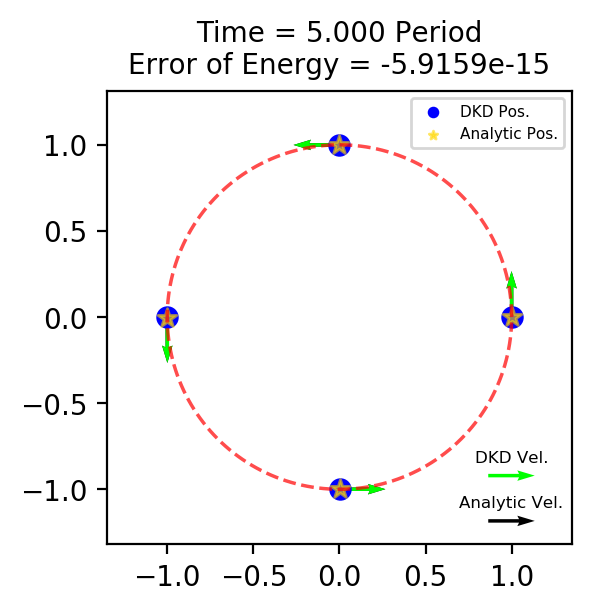

In [5]:
N = 4
theta = 2.*np.pi/N*np.arange(0,N)
x = np.cos(theta)
y = np.sin(theta)
z = np.zeros(N)
# x = np.random.normal(loc=5.0, scale=16., size=N)
# y = np.random.normal(loc=-4.0, scale=8., size=N)
# z = np.random.normal(loc=2.2, scale=4., size=N)
pos = np.vstack((x,y,z))
angle = np.arange(0,2.*np.pi,0.01*np.pi)
XX, YY = np.cos(angle), np.sin(angle)

if N==3:
    v_mag = 3**-0.25
elif N==4:
    v_mag = (1/2**0.5+0.25)**0.5
vx = v_mag*np.cos(theta+np.pi/2.)
vy = v_mag*np.sin(theta+np.pi/2.)
vz = np.zeros(N)
# vx = np.random.normal(loc=0.3, scale=2., size=N)
# vy = np.random.normal(loc=-0.1, scale=1.5, size=N)
# vz = np.random.normal(loc=-0.45, scale=1.6, size=N)
mass = np.ones(N, dtype=np.float64)
# mass = 10.*np.random.uniform(size=N)
vel = np.vstack((vx,vy,vz))
X = MAKE_POS_MATRIX(pos)
M = MAKE_MASS_MATRIX(mass)

dt = 0.005
t = 0.0
index, drawing_resolution = 0, 40
period = 2.0*np.pi/v_mag
end_t = 5.*period
mode = 'DKD'
t_record = []
energy_record = []
energy_analytic = GET_ENERGY(X,M,vel,mass)

plt.figure(figsize=(3,3), dpi=200)
plt.axis('equal')

if mode == 'KDK':
#     X = MAKE_POS_MATRIX(pos)
    acc = GET_ACCELERATION(X,M)
    while t<end_t:
        pos, vel, acc,energy = KDK_SCHEME(pos,vel,M,acc,dt)
        t += dt
        t_record.append(t)
        error_energy = (energy-energy_analytic)/energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
            PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
        index += 1
elif mode == 'DKD':
    while t<end_t:
        pos, vel,energy = DKD_SCHEME(pos,vel,M,dt)
        t += dt
        t_record.append(t)
        error_energy = (energy-energy_analytic)/energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
            PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
            
#         if abs(t-2.5*period)<5e-2:
#             plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW5/snap_shoot_circular_orbit_N=%d_mode=%s.png"\
#                         %(N,mode), bbox_inches='tight', dpi=320, pad_inches=0.05)
        index += 1
elif mode == 'RK4':
    acc = GET_ACCELERATION(X,M)
    while t<end_t:
        pos, vel, X, acc, energy = RK4_SCHEME(pos,vel,M,X,acc,dt)
        t += dt
        t_record.append(t)
        error_energy = (energy-energy_analytic)/energy_analytic
        energy_record.append(error_energy)
        if index%drawing_resolution == 0:
            pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
            PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
        index += 1

t_record = np.array(t_record)
t_record /= 2.*np.pi/v_mag
energy_record = np.array(energy_record)
pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
PLOTTING(pos_analytic,vel_analytic,pos,vel,energy_record[-1])
display.clear_output(wait=True)

In [642]:
error_pos, error_vel = GET_ERROR(pos, pos_analytic, vel, vel_analytic)
print("Error of position is %.8e ; error of velocity is %.8e ."%(error_pos,error_vel))

Error of position is 1.70568087e-03 ; error of velocity is 1.43432306e-03 .


In [643]:
print(pos, pos_analytic)
print(vel, vel_analytic)

[[ 1.00144868e+00 -2.77130902e-03 -9.98543761e-01 -1.33606682e-04]
 [ 3.89052069e-03  9.97424926e-01  1.25393367e-03 -1.00256938e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]] [[ 0.99999907 -0.00136384 -0.99999907  0.00136384]
 [ 0.00136384  0.99999907 -0.00136384 -0.99999907]
 [ 0.          0.          0.          0.        ]]
[[-7.81682231e-05 -9.79543075e-01  2.52095252e-03  9.77100291e-01]
 [ 9.80481036e-01 -3.45160176e-03 -9.76155116e-01 -8.74318494e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]] [[-0.00133427 -0.97831743  0.00133427  0.97831743]
 [ 0.97831743 -0.00133427 -0.97831743  0.00133427]
 [ 0.          0.          0.          0.        ]]


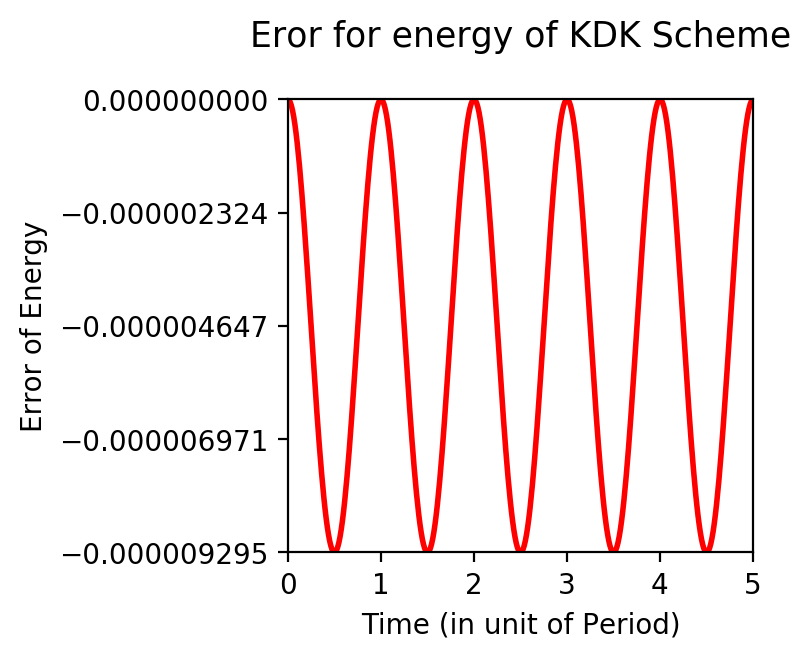

In [7]:
plt.figure(figsize=(3,3), dpi=200)
plt.plot(t_record, energy_record, lw=2.0, c='red')
plt.xlim([0,end_t/period])
plt.ylim([energy_record.min(),1.1*energy_record.max()])
plt.yticks(np.linspace(energy_record.min(),1.1*energy_record.max(),5))
plt.xlabel("Time (in unit of Period)")
plt.ylabel("Error of Energy")
plt.title("Eror for energy of %s Scheme"%mode, y=1.08, fontsize=12.5)
plt.show()

	dt = 0.00500, error min:-1.30326873e-11; error max:2.82034527e-15


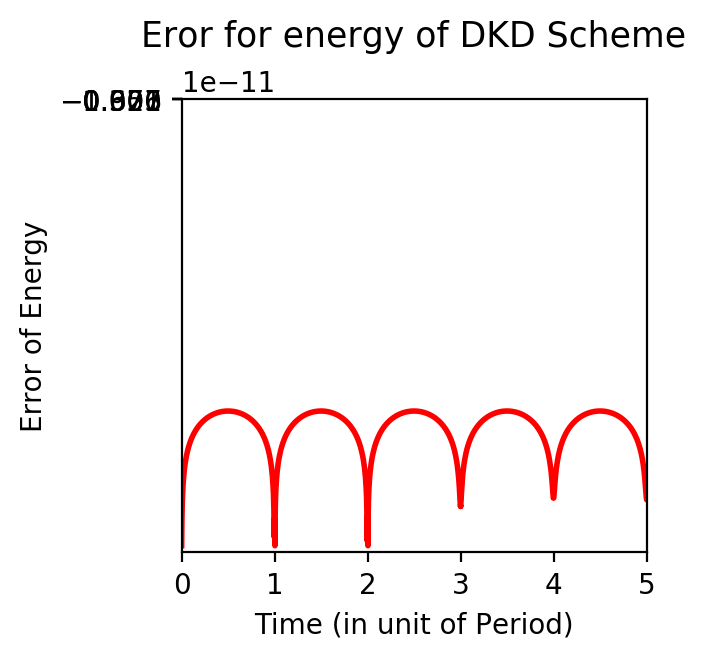

In [21]:
plt.figure(figsize=(3,3), dpi=200)
criteria = abs(energy_record)>=1e-16
plt.plot(t_record[criteria], np.log10(abs(energy_record[criteria])), lw=2.0, c='red')
plt.xlim([0,end_t/period])
# plt.ylim([energy_record.min(),1.1*energy_record.max()])
plt.yticks(np.linspace(energy_record.min(),1.1*energy_record.max(),5))
plt.xlabel("Time (in unit of Period)")
plt.ylabel("Error of Energy")
plt.title("Eror for energy of %s Scheme"%mode, y=1.08, fontsize=12.5)
print("\tdt = %.5f, error min:%.8e; error max:%.8e"%(dt,energy_record[criteria].min(),energy_record[criteria].max()))
plt.show()

In [5]:
import os

N=4
Folder already existed!
	dt=8.000000e-02:
		Error of position is 6.39033032e-02 ; error of velocity is 6.39266941e-02 ; error of energy is -5.48395365e-10 .
	dt=4.000000e-02:
		Error of position is 1.60212407e-02 ; error of velocity is 1.60219355e-02 ; error of energy is -2.70158928e-13 .
	dt=2.000000e-02:
		Error of position is 4.00848180e-03 ; error of velocity is 4.00876698e-03 ; error of energy is 8.34024343e-14 .
	dt=1.000000e-02:
		Error of position is 1.00243928e-03 ; error of velocity is 1.00248561e-03 ; error of energy is 4.98790637e-15 .
	dt=5.000000e-03:
		Error of position is 2.51015657e-04 ; error of velocity is 2.50907680e-04 ; error of energy is -5.91588894e-15 .
	dt=2.500000e-03:
		Error of position is 8.05014103e-05 ; error of velocity is 7.62402395e-05 ; error of energy is 1.27597605e-15 .
	dt=1.250000e-03:
		Error of position is 3.13958981e-05 ; error of velocity is 2.81475433e-05 ; error of energy is -8.23584539e-15 .
N=3
Folder already existed!
	dt=8.000000e-02

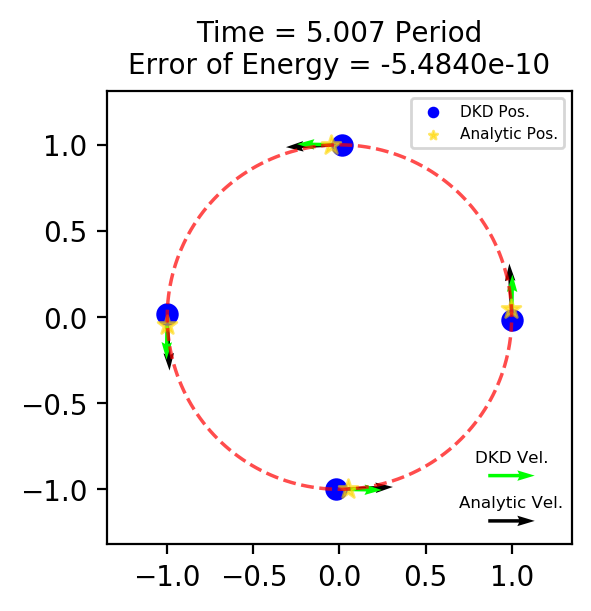

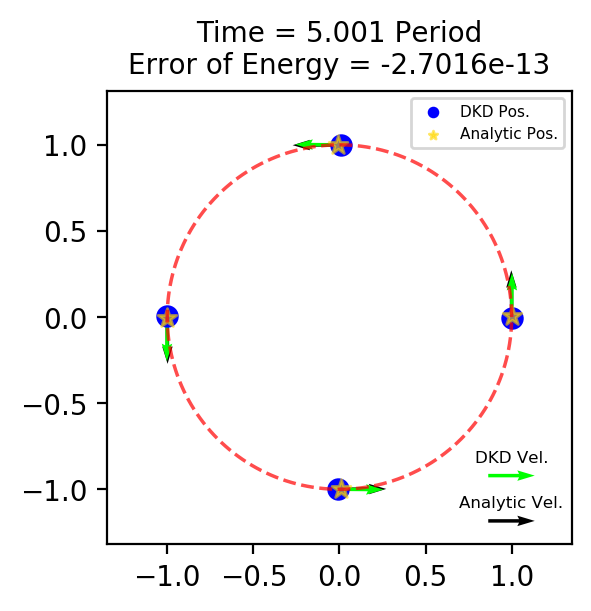

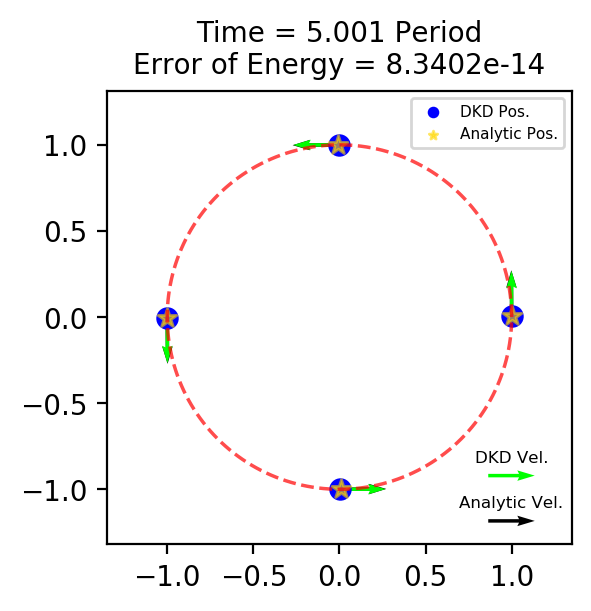

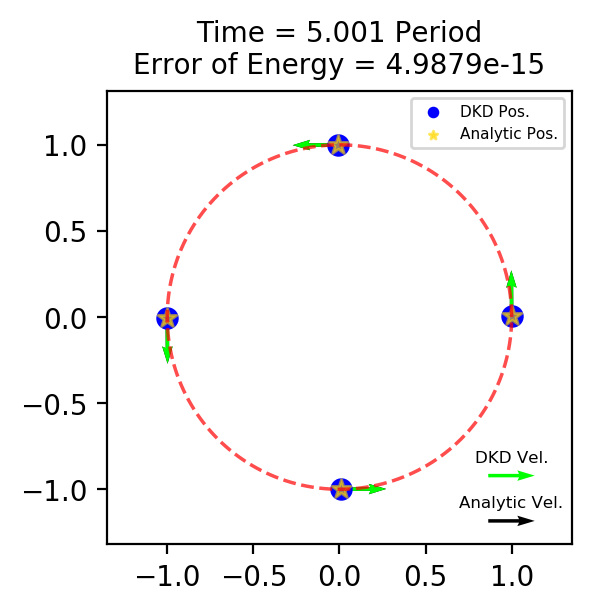

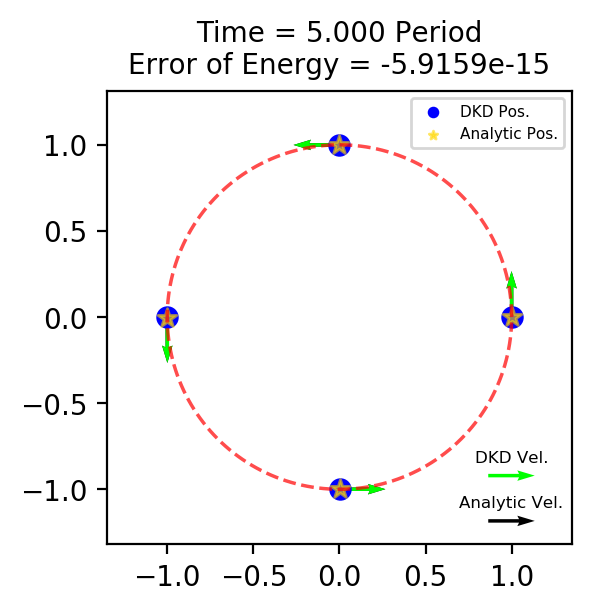

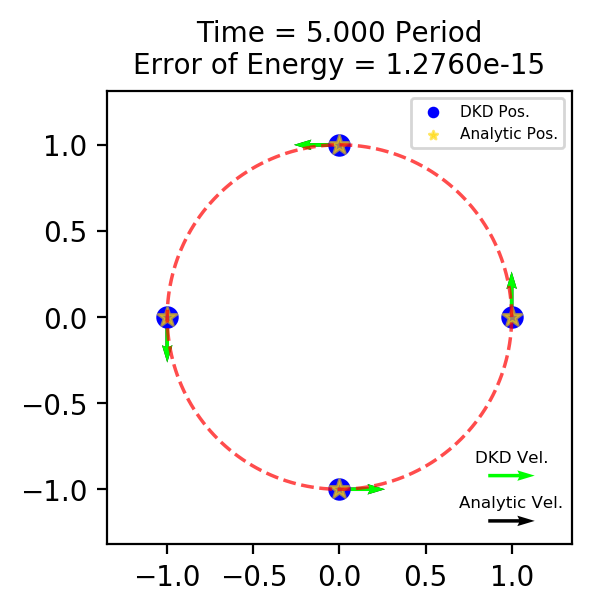

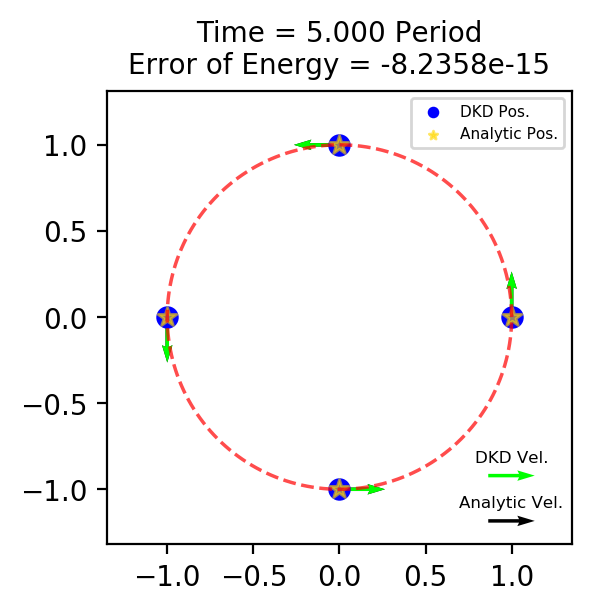

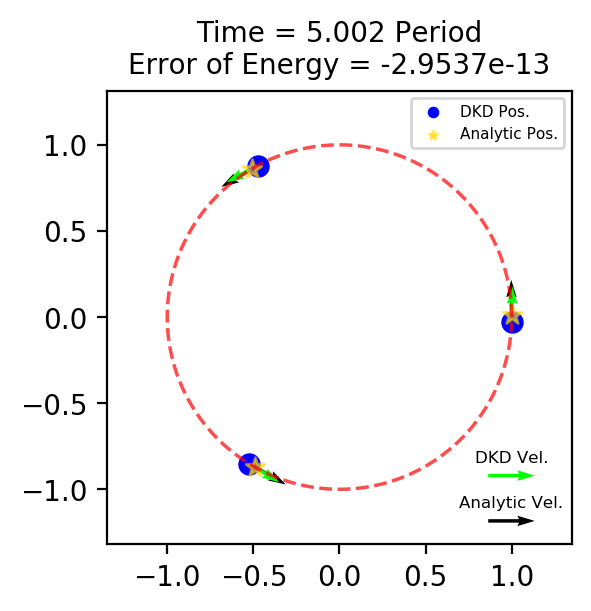

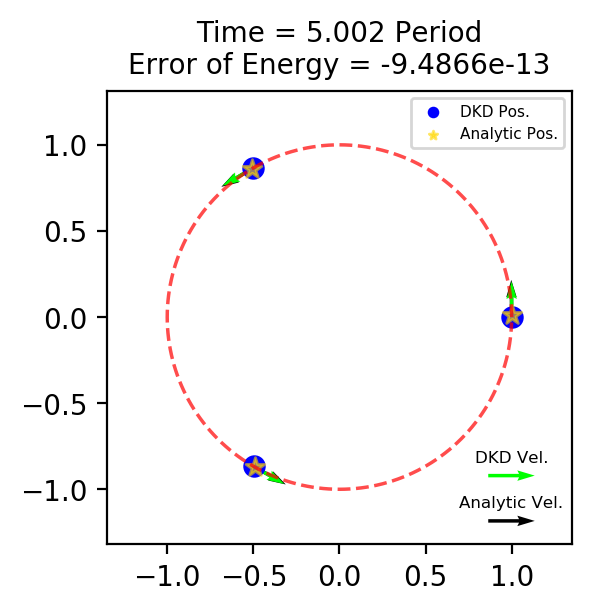

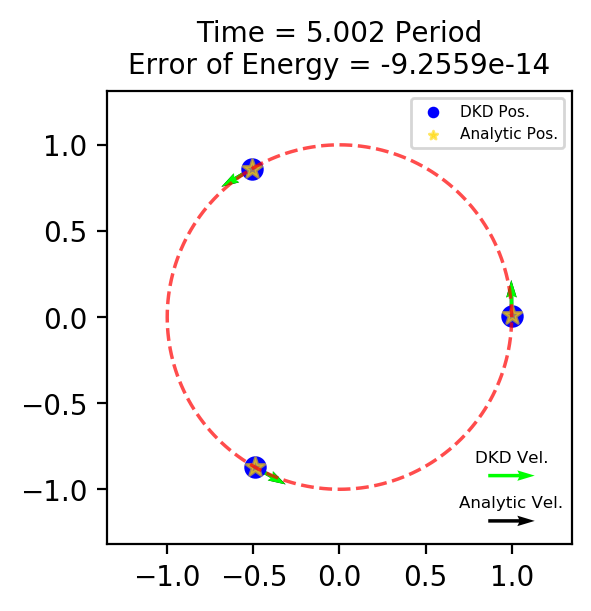

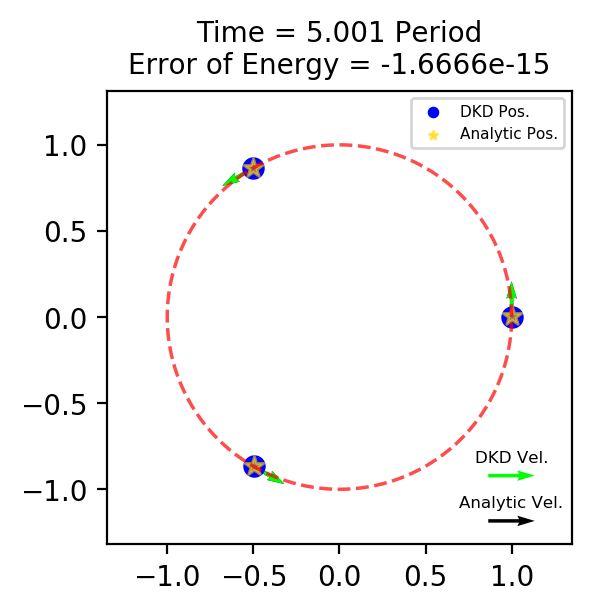

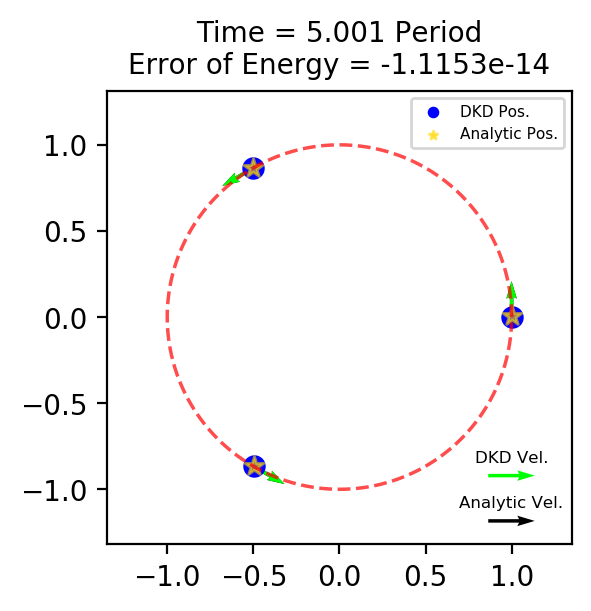

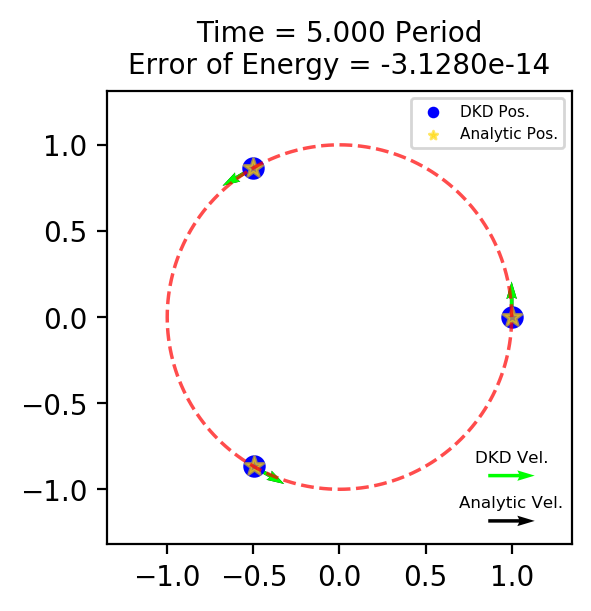

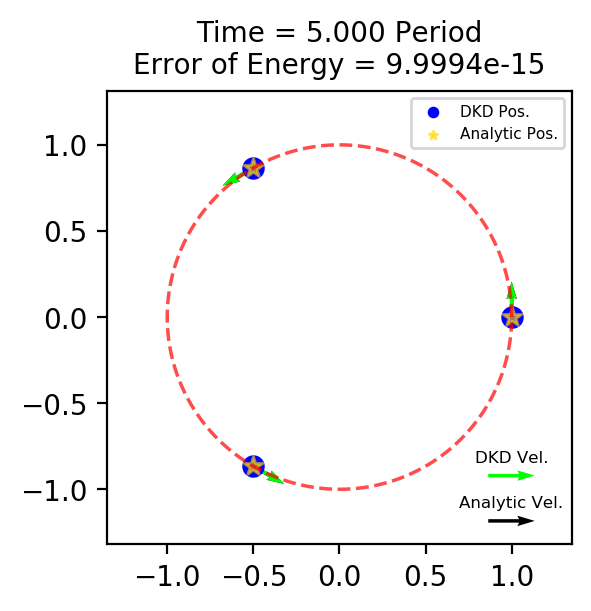

In [9]:
for N in [4,3]:
    print("N=%d"%N)
    theta = 2.*np.pi/N*np.arange(0,N)
    x = np.cos(theta)
    y = np.sin(theta)
    z = np.zeros(N)

    angle = np.arange(0,2.*np.pi,0.01*np.pi)
    XX, YY = np.cos(angle), np.sin(angle)
    if N==3:
        v_mag = 3**-0.25
    elif N==4:
        v_mag = (1/2**0.5+0.25)**0.5
    vx = v_mag*np.cos(theta+np.pi/2.)
    vy = v_mag*np.sin(theta+np.pi/2.)
    vz = np.zeros(N)
    mass = np.ones(N, dtype=np.float64)
    M = MAKE_MASS_MATRIX(mass)

    # index, drawing_resolution = 0, 40
    period = 2.0*np.pi/v_mag
    end_t = 5.*period
    mode = 'DKD'

    path = "./Data_Saving/Circular_Orbit/N=%d_end_t=%.fperiod/"%(N,end_t/period)
    try:
        os.makedirs(path)
    except:
        print("Folder already existed!")

    pos_error_record = []
    vel_error_record = []
    energy_error_record = []
#     if mode!='RK4':
#         dt_range = np.array([8e-2,4e-2,2e-2,1e-2,5e-3,2.5e-3,1.25e-3])
#     else:
#         dt_range = np.array([8e-1,4e-1,2e-1,1e-1,5e-2,2.5e-2,1.25e-2])
    dt_range = np.array([8e-2,4e-2,2e-2,1e-2,5e-3,2.5e-3,1.25e-3])

    for dt in dt_range:
        t = 0.0
        t_record = []
        energy_record = []
        pos_record = []
        vel_record = []
        pos = np.vstack((x,y,z))
        vel = np.vstack((vx,vy,vz))
        X = MAKE_POS_MATRIX(pos)
        energy_analytic = GET_ENERGY(X,M,vel,mass)

        if mode == 'KDK':
            acc = GET_ACCELERATION(X,M)
            while t<end_t:
                pos, vel, acc,energy = KDK_SCHEME(pos,vel,M,acc,dt)
                t += dt
                t_record.append(t)
                error_energy = (energy-energy_analytic)/energy_analytic
                energy_record.append(error_energy)
                pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
                error_pos, error_vel = GET_ERROR(pos, pos_analytic, vel, vel_analytic)
                pos_record.append(error_pos)
                vel_record.append(error_vel)
        #         if index%drawing_resolution == 0:
        #             pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
        #             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
        #         index += 1
        elif mode == 'DKD':
            while t<end_t:
                pos, vel,energy = DKD_SCHEME(pos,vel,M,dt)
                t += dt
                t_record.append(t)
                error_energy = (energy-energy_analytic)/energy_analytic
                energy_record.append(error_energy)
                pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
                error_pos, error_vel = GET_ERROR(pos, pos_analytic, vel, vel_analytic)
                pos_record.append(error_pos)
                vel_record.append(error_vel)
        #         if index%drawing_resolution == 0:
        #             pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
        #             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
        #         index += 1
        elif mode == 'RK4':
            acc = GET_ACCELERATION(X,M)
            while t<end_t:
                pos, vel, X, acc, energy = RK4_SCHEME(pos,vel,M,X,acc,dt)
                t += dt
                t_record.append(t)
                error_energy = (energy-energy_analytic)/energy_analytic
                energy_record.append(error_energy)
                pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
                error_pos, error_vel = GET_ERROR(pos, pos_analytic, vel, vel_analytic)
                pos_record.append(error_pos)
                vel_record.append(error_vel)
        #         if index%drawing_resolution == 0:
        #             pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
        #             PLOTTING(pos_analytic,vel_analytic,pos,vel,error_energy)
        #         index += 1

        t_record = np.array(t_record)
        t_record /= 2.*np.pi/v_mag
        energy_record = np.array(energy_record)
        pos_record = np.array(pos_record)
        vel_record = np.array(vel_record)
        pos_analytic, vel_analytic = GET_ANALYTIC_RESULT(t, theta)
        error_pos, error_vel = GET_ERROR(pos, pos_analytic, vel, vel_analytic)
        print("\tdt=%.6e:"%dt)
        print("\t\tError of position is %.8e ; error of velocity is %.8e ; error of energy is %.8e ."\
              %(error_pos,error_vel,energy_record[-1]))
        pos_error_record.append(error_pos)
        vel_error_record.append(error_vel)
        energy_error_record.append(energy_record[-1])

        plt.figure(figsize=(3,3), dpi=200)
        plt.axis('equal')
        plt.plot(XX, YY, lw = 1.25, color='red', ls='--', alpha=0.7)
        q1 = plt.quiver(pos_analytic[0],pos_analytic[1],vel_analytic[0],vel_analytic[1], color='k', scale=10.0)
        plt.quiverkey(q1, 0.87,0.05,1.,'Analytic Vel.', fontproperties={'size':6.0}, labelsep=0.05)
        q2 = plt.quiver(pos[0],pos[1],vel[0],vel[1], color='lime', scale=10.0)
        plt.quiverkey(q2, 0.87,0.15,1.,'%s Vel.'%mode, fontproperties={'size':6.0}, labelsep=0.05)
        plt.scatter(pos[0], pos[1], s=50.0, color='blue', label='%s Pos.'%mode)
        plt.scatter(pos_analytic[0], pos_analytic[1], s=50.0, color='gold', label='Analytic Pos.', alpha=0.6, marker="*")
        plt.xlim(-1.35, 1.35)
        plt.xticks(np.linspace(-1.0,1.0,5))
        plt.ylim(-1.35, 1.35)
        plt.yticks(np.linspace(-1.0,1.0,5))
        plt.title("Time = %.3f Period\nError of Energy = %.4e"%(t/period, error_energy),fontsize=10.)
        lgnd=plt.legend(loc='upper right', prop={'size':5.5})
        lgnd.legendHandles[0]._sizes = [10]
        lgnd.legendHandles[1]._sizes = [10]

        with open(path+"mode=%s_dt=%s.txt"%(mode,dt),"w") as file:
            file.write("#\tTime\tError_of_Energy\tError_of_Position\tError_of_Velocity\n")
            np.savetxt(file, np.vstack((t_record,energy_record, pos_record, vel_record)).T, fmt='%.8e')
            file.close()

    pos_error_record = np.array(pos_error_record)
    vel_error_record = np.array(vel_error_record)
    energy_error_record = np.array(energy_error_record)

    with open(path+"mode=%s_pos_and_vel_error.txt"%mode,"w") as file:
        file.write("#\tdt\tError_of_Position\tError_of_Velocity\tError_of_Energy\n")
        np.savetxt(file, np.vstack((dt_range,pos_error_record,vel_error_record,energy_error_record)).T, fmt='%.8e')
        file.close()